<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

This notebook demonstrates how to extract event triggered averages from timeseries collected at different acquisition rates during neurophysiology experiments. 

</div>


In [52]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [53]:
# prefered magic functions for jupyter notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Accessing data with the AllenSDK</h3>
<p>

The `brain_observatory_utilities` repo is designed to work with datasets collected at the Allen Institute using the Brain Observatory pipeline for neurophysiology and behavior. There are several Brain Observatory datasets, which you can learn about here: 

https://portal.brain-map.org/circuits-behavior

In this demo, we will use the <b>Visual Behavior Ophys</b> dataset, which is comprised of data from 107 mice performing a change detection task while neural activity was recorded using in vivo 2-photon calcium imaging. You can learn more about this dataset here: 

https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html 

This dataset can be accessed using the `AllenSDK` toolkit. Most functions in `brain_observatory_utilities` are designed to work with data formatted as python objects produced by the `AllenSDK`.  

</div>


In [54]:
# confirm that you are currently using the newest version of SDK (2.16.2)
import allensdk
allensdk.__version__

'2.16.2'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

To identify experiments of interest in this dataset based on features of the experiment, such as what cell populations were imaged, what types of sessions there were, etc., we need to access the metadata tables provided by the `VisualBehaviorOphysProjectCache` of the `AllenSDK`.

The `VisualBehaviorOphysProjectCache` class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded into data assets on CodeOcean - These data are big, and this will save us a lot of bandwidth and time.

</div>


The code below shows you how to use the `VisualBehaviorOphysProjectCache` class to load metadata tables & explore the features of the dataset.

In [55]:
# This is the directory where files will be saved
# If using Code Ocean, this should link to the data directory, where the files will already be available
output_dir = r'/Users/marinag/Documents/Data/visual_behavior_ophys_cache_dir'

In [56]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=output_dir)

/Users/marinag/anaconda3/envs/swdb_2024/lib/python3.8/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


Load the `ophys_experiment_table` to identify all imaging planes recorded in this dataset

In [57]:
ophys_experiment_table = cache.get_ophys_experiment_table()    

print('Number of ophys experiments = {}'.format(len(ophys_experiment_table)))

Number of ophys experiments = 1936


In [58]:
ophys_experiment_table.head()

,behavior_session_id,ophys_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,...,passive,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,published_at,isi_experiment_id,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
951980471,951520319,951410079,1018028342,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,0
951980473,951520319,951410079,1018028345,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,1
951980475,951520319,951410079,1018028339,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,2
951980479,951520319,951410079,1018028354,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,3
951980481,951520319,951410079,1018028357,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,4


The metadata tables include a number of key details for understanding the dataset, such as - where the recordings were made, what type of cells were labeled, and what stimulus was shown in a given session. 

In [59]:
# Check what genotypes are available 
print(ophys_experiment_table.full_genotype.unique())

['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt']


Pick a cre line to look at experiments for a specific cell population, then pick a mouse & session to analyze

In [60]:
# Filter by cre_line to get just the Vip mice, then print out the unique values of mouse_id, sorted in ascending order
cre_line = 'Vip-IRES-Cre'
sst_mice = ophys_experiment_table[(ophys_experiment_table.cre_line==cre_line)].mouse_id.unique()
print(np.sort(sst_mice))

['412036' '421136' '429952' '435431' '438912' '449653' '453988' '453989'
 '453990' '453991' '467951' '467953' '467954' '468866' '486737' '489065'
 '489066' '492395' '499478' '523922' '523927' '528097' '538219' '544261'
 '550603' '554115' '563231' '563234']


In [61]:
# Pick a mouse
special_mouse_id = '554115'

In [62]:
# Get all session types for this mouse
ophys_experiment_table[ophys_experiment_table.mouse_id==special_mouse_id].session_type.unique()

array(['OPHYS_1_images_G', 'OPHYS_2_images_G_passive', 'OPHYS_3_images_G',
       'OPHYS_4_images_H', 'OPHYS_5_images_H_passive', 'OPHYS_6_images_H'],
      dtype=object)

In [63]:
# Get the session metadata for this mouse for `OPHYS_4_images_H`
experiments = ophys_experiment_table[(ophys_experiment_table.mouse_id==special_mouse_id) & 
                                (ophys_experiment_table.session_type=='OPHYS_4_images_H')]
experiments.head()

,behavior_session_id,ophys_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,...,passive,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,published_at,isi_experiment_id,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
1098444819,1098360551,1098326266,1095625228,554115,GCaMP6f,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Vip-IRES-Cre],Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,...,False,Novel 1,0,0,4,2021-04-22 11:15:14.707000+00:00,MESO.1,2021-08-12,1067796411,652
1098444821,1098360551,1098326266,1095625231,554115,GCaMP6f,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Vip-IRES-Cre],Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,...,False,Novel 1,0,0,4,2021-04-22 11:15:14.707000+00:00,MESO.1,2021-08-12,1067796411,653
1098444822,1098360551,1098326266,1095625235,554115,GCaMP6f,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Vip-IRES-Cre],Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,...,False,Novel 1,0,0,4,2021-04-22 11:15:14.707000+00:00,MESO.1,2021-08-12,1067796411,654
1098444824,1098360551,1098326266,1095625238,554115,GCaMP6f,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Vip-IRES-Cre],Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,...,False,Novel 1,0,0,4,2021-04-22 11:15:14.707000+00:00,MESO.1,2021-08-12,1067796411,655
1098444826,1098360551,1098326266,1095625243,554115,GCaMP6f,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Vip-IRES-Cre],Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,...,False,Novel 1,0,0,4,2021-04-22 11:15:14.707000+00:00,MESO.1,2021-08-12,1067796411,656


In [64]:
# What is the experience_level for this session?
experiments[['session_type', 'experience_level', 'prior_exposures_to_image_set']]

,session_type,experience_level,prior_exposures_to_image_set
ophys_experiment_id,,,
1098444819,OPHYS_4_images_H,Novel 1,0
1098444821,OPHYS_4_images_H,Novel 1,0
1098444822,OPHYS_4_images_H,Novel 1,0
1098444824,OPHYS_4_images_H,Novel 1,0
1098444826,OPHYS_4_images_H,Novel 1,0
1098444828,OPHYS_4_images_H,Novel 1,0
1098444829,OPHYS_4_images_H,Novel 1,0
1098444831,OPHYS_4_images_H,Novel 1,0


This is an Ophys session with Novel images. Our special mouse has never seen this image set before (prior exposures = 0)

Which brain areas and cortical depths were recorded?

In [65]:
# Print out the targeted structures and the imaging depths
print(experiments.targeted_structure.unique())
print(experiments.imaging_depth.unique())

['VISp' 'VISl' 'VISal' 'VISam']
[150 245 185 305 205 255 175 244]


In [66]:
# We can also look at both of these pieces of information at once by limiting the table just to those columns (plus a few others that might be interesting)
experiments[['targeted_structure', 'imaging_depth', 'session_type', 'experience_level', 'equipment_name']]

,targeted_structure,imaging_depth,session_type,experience_level,equipment_name
ophys_experiment_id,,,,,
1098444819,VISp,150,OPHYS_4_images_H,Novel 1,MESO.1
1098444821,VISp,245,OPHYS_4_images_H,Novel 1,MESO.1
1098444822,VISl,185,OPHYS_4_images_H,Novel 1,MESO.1
1098444824,VISl,305,OPHYS_4_images_H,Novel 1,MESO.1
1098444826,VISal,205,OPHYS_4_images_H,Novel 1,MESO.1
1098444828,VISal,255,OPHYS_4_images_H,Novel 1,MESO.1
1098444829,VISam,175,OPHYS_4_images_H,Novel 1,MESO.1
1098444831,VISam,244,OPHYS_4_images_H,Novel 1,MESO.1


Lets pick an imaging plane from VISam at 175um depth

In [67]:
targeted_structure = 'VISam'
imaging_depth = 175
ophys_experiment_id = experiments[(experiments.targeted_structure==targeted_structure) & 
                                    (experiments.imaging_depth==imaging_depth)].index.values[0]
print(ophys_experiment_id)

1098444829


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h3> Physiology data </h3>

To load the data for a single imaging plane recorded in a given session, we can use the `get_behavior_ophys_experiment` method of the `VisualBehaviorOphysProjectCache` class that we instantiated previously as `cache`. 

This method returns a python object that contains all data and metadata for a given recording as attributes, along with some useful functions. We typically name this python object simply `dataset`.

In [68]:
# Load the dataset for the ophys_experiment_id we selected 
dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id)

/Users/marinag/anaconda3/envs/swdb_2024/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [69]:
# Look at the metadata attribute
dataset.metadata

{'equipment_name': 'MESO.1',
 'sex': 'M',
 'age_in_days': 213,
 'stimulus_frame_rate': 60.0,
 'session_type': 'OPHYS_4_images_H',
 'date_of_acquisition': datetime.datetime(2021, 4, 22, 11, 15, 14, 707000, tzinfo=tzutc()),
 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)',
 'cre_line': 'Vip-IRES-Cre',
 'behavior_session_uuid': UUID('a5f19ac2-5eca-45f2-bd97-55d8569c9432'),
 'driver_line': ['Vip-IRES-Cre'],
 'mouse_id': '554115',
 'project_code': 'VisualBehaviorMultiscope4areasx2d',
 'full_genotype': 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
 'behavior_session_id': 1098360551,
 'indicator': 'GCaMP6f',
 'emission_lambda': 520.0,
 'excitation_lambda': 910.0,
 'ophys_container_id': 1095625254,
 'field_of_view_height': 512,
 'field_of_view_width': 512,
 'imaging_depth': 175,
 'targeted_imaging_depth': 175,
 'imaging_plane_group': 3,
 'imaging_plane_group_count': 4,
 'ophys_experiment_id': 1098444829,
 'ophys_frame_rate': 11.0,
 'ophys_session_id': 1098326266,
 'targeted_structure': 'VISam

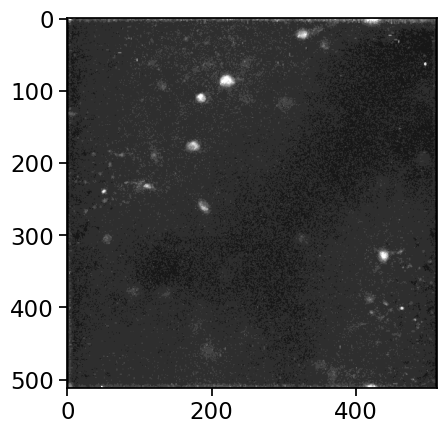

In [70]:
# Look at the cells that were imaged
plt.imshow(dataset.max_projection, cmap='gray')

In [71]:
# Get cell traces
dataset.dff_traces.head()

,cell_roi_id,dff
cell_specimen_id,,
1120127239,1115332389,"[0.980219546219401, 0.6094534513192065, 0.6853..."
1120127768,1115332397,"[1.169409383054738, 0.9979296223912821, 0.9934..."
1120128009,1115332401,"[0.9362860526823751, 0.7454556582675054, 0.755..."
1120127465,1115332403,"[0.20766086155300395, 0.6513588622141365, 0.71..."
1120127586,1115332407,"[0.3067842153166964, 0.6835304837264211, 0.416..."


Pick one cell and plot its activity

In [72]:
# Get cell_specimen_id from the cell_specimen_table. Can also get from either the dff_traces or events
cell_specimen_ids = dataset.cell_specimen_table.index.values # a list of all cell ids
cell_specimen_id = cell_specimen_ids[5] # pick the first cell
print('Cell specimen id = {}'.format(cell_specimen_id)) # print the cell ID

Cell specimen id = 1120127668


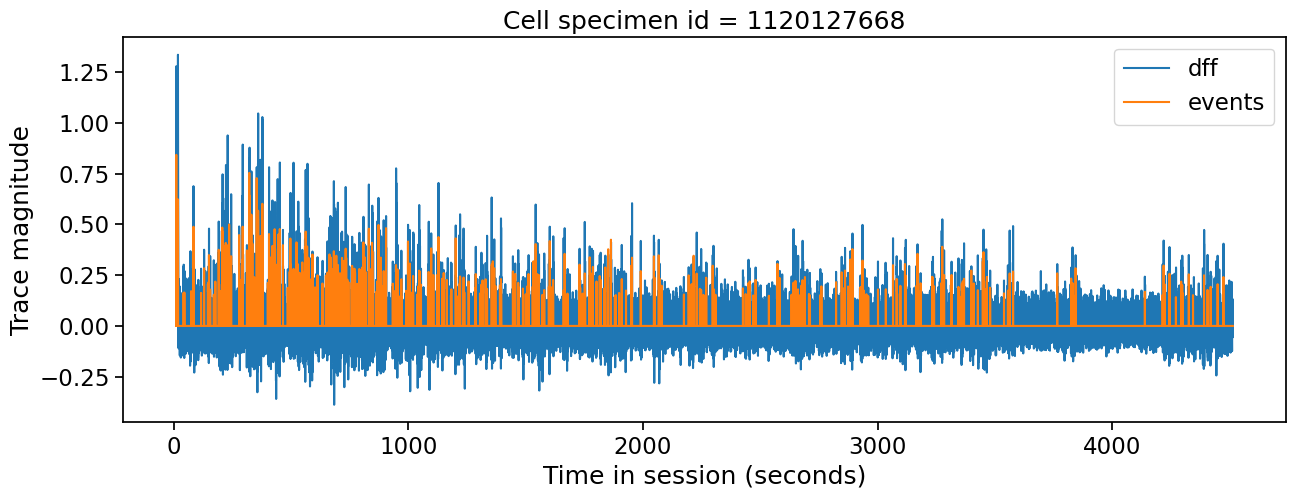

In [73]:
# Plot dff and events traces overlaid from the cell selected above
fig, ax = plt.subplots(1, 1, figsize = (15,5))
ax.plot(dataset.ophys_timestamps, dataset.dff_traces.loc[cell_specimen_id]['dff'], label='dff')
ax.plot(dataset.ophys_timestamps, dataset.events.loc[cell_specimen_id]['events'], label='events')
ax.set_xlabel('Time in session (seconds)')
ax.set_ylabel('Trace magnitude')
ax.set_title('Cell specimen id = {}'.format(cell_specimen_id))
ax.legend()


What is this cell responding to? 

To find out, we need to align to stimulus presentations or some other task event

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h3> Stimulus information </h3>

We can look at the `stimulus_presentations` table to look at what stimuli were shown, along with other relevant metadata about the task flow. 

In [74]:
# What does the stimulus_presentations table look like? 
dataset.stimulus_presentations.head()

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,stimulus_name,active,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
0,0,initial_gray_screen_5min,-99,NaN,-99,309.30762,0.00000,309.30762,0,17985,False,<NA>,<NA>,-99,0,-99,spontaneous,False,False
1,1,change_detection_behavior,0,im104_r,-99,0.25020,309.30762,309.55782,17985,18000,False,True,False,-99,1,0,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
2,1,change_detection_behavior,0,im104_r,-99,0.25020,310.05823,310.30843,18030,18045,False,True,False,-99,2,0,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
3,1,change_detection_behavior,0,im104_r,-99,0.25021,310.80884,311.05905,18075,18090,False,True,False,-99,3,1,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
4,1,change_detection_behavior,0,im104_r,-99,0.25020,311.55946,311.80966,18120,18135,False,True,False,-99,4,1,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False


In [75]:
# What are the stimulus blocks?
dataset.stimulus_presentations.stimulus_block_name.unique()

array(['initial_gray_screen_5min', 'change_detection_behavior',
       'post_behavior_gray_screen_5min', 'natural_movie_one'],
      dtype=object)

In [76]:
# Assign the table to a new variable
stimulus_table = dataset.stimulus_presentations.copy()

In [77]:
# Limit to change detection behavior block
stimulus_table = stimulus_table[stimulus_table.stimulus_block_name=='change_detection_behavior']
stimulus_table.head()

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,stimulus_name,active,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
1,1,change_detection_behavior,0,im104_r,-99,0.25020,309.30762,309.55782,17985,18000,False,True,False,-99,1,0,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
2,1,change_detection_behavior,0,im104_r,-99,0.25020,310.05823,310.30843,18030,18045,False,True,False,-99,2,0,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
3,1,change_detection_behavior,0,im104_r,-99,0.25021,310.80884,311.05905,18075,18090,False,True,False,-99,3,1,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
4,1,change_detection_behavior,0,im104_r,-99,0.25020,311.55946,311.80966,18120,18135,False,True,False,-99,4,1,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
5,1,change_detection_behavior,0,im104_r,-99,0.25019,312.31006,312.56025,18165,18180,False,True,False,-99,5,2,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False


This table provides helpful information like image name, start, duration and stop of image presentation, and whether the image was omitted. 

In [78]:
# Count all stimulus presentations
print(len(stimulus_table), 'stimulus presentations total')

# Count the changes
print(len(stimulus_table[stimulus_table.is_change==True]), 'stimulus presentations were changes')

# Count the omissions
print(len(stimulus_table[stimulus_table.omitted==True]), 'stimulus presentations were omitted')

4803 stimulus presentations total
172 stimulus presentations were changes
180 stimulus presentations were omitted


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h4> Timestamps </h4>

Now that we know how to get the stimuli for this session, we want to ask how neurons respond to different types of stimuli. 
This means we need to know when a given stimulus happened relative to the neural recordings. 

All the data in each session was recorded on a common clock, however not all data streams were sampled at the same rate. 
Let's examine the timestamps to understand the differences


In [79]:
# Stimulus timestamps
dataset.stimulus_timestamps

array([   9.25938,    9.27603,    9.29274, ..., 4515.24068, 4515.25733,
       4515.27404])

In [80]:
# Ophys timestamps
dataset.ophys_timestamps

array([   9.31287,    9.40636,    9.49986, ..., 4515.12707, 4515.2206 ,
       4515.31412])

In [81]:
# Stimulus frame rate
1/np.mean(np.diff(dataset.stimulus_timestamps))

59.94987153459461

In [82]:
# Ophys frame rate
1/np.mean(np.diff(dataset.ophys_timestamps))

10.69262907994089

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h3> Aligning stimulus & phyisology data </h3>

As we saw above, the ophys data and stimulus presentations are not recorded at the same rate. 
If we want to compute stimulus aligned cell activity, we will need a way to associate ophys timestamps with the nearest stimulus timestamps. 

Fortunately, the `brain_observatory_utilities` package provides tools to make this easier. 

There are to main modules in this repo that are useful for aligning different timeseries: 

`datasets.optical_physiology.data_formatting`: provides tools for reformatting ophys data (events and dff traces) to align to stimulus times. We will use this module below.

`utilities.general_utilities`: provides tools for general purpose slicing and dicing of timeseries data, provided it is in the expected format. This module contains the functions that `data_formatting` relies on to work, and can be useful for other types of data as well (like electrophysiology). We wont be using this module right now, but see the mini-tutorial at the end of the notebook for more info about it. 

In [83]:
import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h4> Get stimulus response dataframe </h4>

We can use the `get_stimulus_response_df` function from the `datasets.optical_physiology.data_formatting` module to get the stimulus locked activity for all cells in the dataset. 

Let's look at the documentation for this function


In [84]:
# Let's look at the documentation for the get_stimulus_response_df function
data_formatting.get_stimulus_response_df?

Signature:
data_formatting.get_stimulus_response_df(
    ophys_experiment,
    data_type='dff',
    event_type='all',
    time_window=[-3, 3],
    response_window_duration=0.5,
    interpolate=True,
    output_sampling_rate=None,
    exclude_invalid_rois=True,
    **kwargs,
)
Docstring:
Get stimulus aligned responses from one ophys_experiment.

Parameters:
___________
ophys_experiment: obj
    AllenSDK BehaviorOphysExperiment object
    A BehaviorOphysExperiment instance
    See https://github.com/AllenInstitute/AllenSDK/blob/master/allensdk/brain_observatory/behavior/behavior_ophys_ophys_experiment.py  # noqa E501
data_type: str
    neural or behavioral data type to extract, options are: dff (default), events, filtered_events, running_speed, pupil_diameter, lick_rate
event_type: str
    event type to align to, which can be found in columns of ophys_experiment.stimulus_presentations df.
    options are: 'all' (default) - gets all stimulus trials
                 'images' - gets only im

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

The `get_stimulus_response` function is smart and already knows what our data structures look like, 
so it can pull out the relevant information from the cell activity tables (`dff_traces` and `events`) 
and from the `stimulus_presentations` table.

The `ophys_experiment` argument to the `get_stimulus_response` function is an instance of the dataset object that we have been working with.

The `data_type` argument is which cell timeseries you want to use, either 'dff', 'events', or 'filtered_events'.

The `event_type` argument can be used to sub-select the `stimulus_presentations` table. 
If `all` is provided, the function will get stimulus locked responses for every stimulus presentation over the entire session.
If `event_type` = `changes`, only image changes will be sampled. 
If `event_type` = `omissions`, only omissions will be sampled. 

The `time_window` argument is the time, in seconds, around each event over which you would like to sample the cell traces. 
It is formatted as an array of 2 values with time before and time after, such as [-1,1].

The `response_window_duration` is the duration, in seconds, following the stimulus onset time over which you would like to compute an average image evoked response. If `response_window_duration` is 0.5 seconds, the average of the dff or events trace in a 500ms window following stimulus onset will be computed stimulus presentation, resulting in a single value representing the mean response for each cell on each trial. 

If the `interpolate` argument is set to `True` (which is the default value), and a value is also provided for `output_sampling_rate`, 
the `event_triggered_response` funciton will automatically interpolate the timeseries provided in `data` to the provided `output_sampling_rate`. Setting `interpolate` to `False` means that the native frame rate of the data will be used. 

In [85]:
# Get stimulus aligned responses for all cells in this dataset
stim_response_df = data_formatting.get_stimulus_response_df(dataset, data_type='dff', event_type='changes',
                                                            time_window=[-1, 1], response_window_duration=0.5,
                                                            interpolate=True, output_sampling_rate=None)
stim_response_df.head()

100%|██████████| 6/6 [00:00<00:00, 57.72it/s]


,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,ophys_frame_rate,data_type,event_type,interpolate,output_sampling_rate,response_window_duration
0,46,1120127239,"[0.10333100039412649, 0.10333100039412649, 0.1...","[-1.0, -0.9844132081247773, -0.968826416249554...",-0.048619,-0.004189,1.0,11.0,dff,changes,True,None,0.5
1,46,1120127465,"[0.3363297264428418, 0.3363297264428418, 0.336...","[-1.0, -0.9844132081247773, -0.968826416249554...",0.181188,0.086779,0.0,11.0,dff,changes,True,None,0.5
2,46,1120127586,"[0.07928729792538908, 0.07928729792538908, 0.0...","[-1.0, -0.9844132081247773, -0.968826416249554...",-0.013183,0.014776,1.0,11.0,dff,changes,True,None,0.5
3,46,1120127668,"[0.023717660731315038, 0.023717660731315038, 0...","[-1.0, -0.9844132081247773, -0.968826416249554...",0.151330,0.218430,0.0,11.0,dff,changes,True,None,0.5
4,46,1120127768,"[0.05608113224722963, 0.05608113224722963, 0.0...","[-1.0, -0.9844132081247773, -0.968826416249554...",-0.034861,0.087595,1.0,11.0,dff,changes,True,None,0.5


Note that the stim_response_df contains the index of the `stimulus_presentations` table, the `stimulus_presentations_id`. 

In [86]:
# Merge the stimulus response dataframe with the stimulus table to get information about what stimuli were presented 
stim_response_df = stim_response_df.merge(stimulus_table, on='stimulus_presentations_id')
stim_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,ophys_frame_rate,data_type,event_type,...,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,stimulus_name,active,is_sham_change
0,46,1120127239,"[0.10333100039412649, 0.10333100039412649, 0.1...","[-1.0, -0.9844132081247773, -0.968826416249554...",-0.048619,-0.004189,1.0,11.0,dff,changes,...,20025,True,True,False,-99,0,13,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
1,46,1120127465,"[0.3363297264428418, 0.3363297264428418, 0.336...","[-1.0, -0.9844132081247773, -0.968826416249554...",0.181188,0.086779,0.0,11.0,dff,changes,...,20025,True,True,False,-99,0,13,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
2,46,1120127586,"[0.07928729792538908, 0.07928729792538908, 0.0...","[-1.0, -0.9844132081247773, -0.968826416249554...",-0.013183,0.014776,1.0,11.0,dff,changes,...,20025,True,True,False,-99,0,13,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
3,46,1120127668,"[0.023717660731315038, 0.023717660731315038, 0...","[-1.0, -0.9844132081247773, -0.968826416249554...",0.151330,0.218430,0.0,11.0,dff,changes,...,20025,True,True,False,-99,0,13,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
4,46,1120127768,"[0.05608113224722963, 0.05608113224722963, 0.0...","[-1.0, -0.9844132081247773, -0.968826416249554...",-0.034861,0.087595,1.0,11.0,dff,changes,...,20025,True,True,False,-99,0,13,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False


In [87]:
# Check out the columns available
stim_response_df.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'trace_timestamps', 'mean_response', 'baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       'interpolate', 'output_sampling_rate', 'response_window_duration',
       'stimulus_block', 'stimulus_block_name', 'image_index', 'image_name',
       'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'trials_id', 'stimulus_name',
       'active', 'is_sham_change'],
      dtype='object')

In [88]:
# Whats up with the timestamps
stim_response_df.trace_timestamps

0       [-1.0, -0.9844132081247773, -0.968826416249554...
1       [-1.0, -0.9844132081247773, -0.968826416249554...
2       [-1.0, -0.9844132081247773, -0.968826416249554...
3       [-1.0, -0.9844132081247773, -0.968826416249554...
4       [-1.0, -0.9844132081247773, -0.968826416249554...
                              ...                        
1027    [-1.0, -0.9844132081247773, -0.968826416249554...
1028    [-1.0, -0.9844132081247773, -0.968826416249554...
1029    [-1.0, -0.9844132081247773, -0.968826416249554...
1030    [-1.0, -0.9844132081247773, -0.968826416249554...
1031    [-1.0, -0.9844132081247773, -0.968826416249554...
Name: trace_timestamps, Length: 1032, dtype: object

In [89]:
# The timestamps are all the same and they span from -1 to 1, just as we requested when we created the stim_response_df
stim_response_df.trace_timestamps.values[0]

array([-1.        , -0.98441321, -0.96882642, -0.95323962, -0.93765283,
       -0.92206604, -0.90647925, -0.89089246, -0.87530566, -0.85971887,
       -0.84413208, -0.82854529, -0.8129585 , -0.79737171, -0.78178491,
       -0.76619812, -0.75061133, -0.73502454, -0.71943775, -0.70385095,
       -0.68826416, -0.67267737, -0.65709058, -0.64150379, -0.62591699,
       -0.6103302 , -0.59474341, -0.57915662, -0.56356983, -0.54798304,
       -0.53239624, -0.51680945, -0.50122266, -0.48563587, -0.47004908,
       -0.45446228, -0.43887549, -0.4232887 , -0.40770191, -0.39211512,
       -0.37652832, -0.36094153, -0.34535474, -0.32976795, -0.31418116,
       -0.29859437, -0.28300757, -0.26742078, -0.25183399, -0.2362472 ,
       -0.22066041, -0.20507361, -0.18948682, -0.17390003, -0.15831324,
       -0.14272645, -0.12713965, -0.11155286, -0.09596607, -0.08037928,
       -0.06479249, -0.0492057 , -0.0336189 , -0.01803211, -0.00244532,
        0.01314147,  0.02872826,  0.04431506,  0.05990185,  0.07

Looks like the timestamps go from -1 to 1 second around the stimulus onset time, just like we asked for when we ran the `get_stimulus_response_df` function!! 

Text(0, 0.5, 'dF/F')

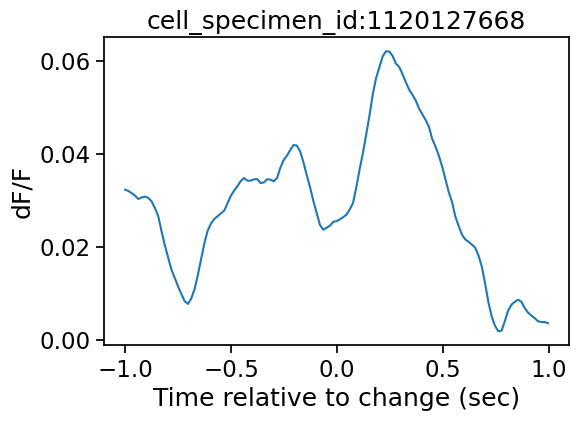

In [90]:
# Plot the average response for the cell we care about

# get the relevant data
cell_df = stim_response_df[stim_response_df.cell_specimen_id==cell_specimen_id]
# get the average dff trace
mean_trace = cell_df.trace.mean()
# get the timestamps for one row ()
timestamps = cell_df.trace_timestamps.values[0]

# make the plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(timestamps, mean_trace)
ax.set_title('cell_specimen_id:'+str(cell_specimen_id))
ax.set_xlabel('Time relative to change (sec)')
ax.set_ylabel('dF/F')


Looks like this cell increases its activity following image onset, but the response to the image change and the repeated image before the change are pretty similar. I wonder if thats a property of all Sst neurons, or just this one...

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h3> Event triggered response function </h3>

The `get_stimulus_response_df` is very abstracted, it takes in an entire python obejct, and returns a highly processed dataframe of cell activity. 
But how did it do that? What is underneath the hood? 

The `brain_observatory_utilities` also has a utilities module, `utilities.general_utilities`, that can be used with any arbitrary timeseries and event times to get event aligned traces.

But first the data needs to be formatted into a "tidy" dataframe. 


In [91]:
import brain_observatory_utilities.utilities.general_utilities as general_utilities

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

We can use the `build_tidy_cell_df` function to get a "tidy" (aka "long form") dataframe where each row is 1 observation (i.e. one ophys timepoint). 

The function takes in the entire ophys dataset object, and extracts the values for `dff`, `events`, and `filtered_events` from the relevant attribtues of the dataset object, along with the `ophys_timestamps` and cell IDs.

In [92]:
tidy_cell_df = data_formatting.build_tidy_cell_df(dataset)
tidy_cell_df

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id
0,9.31287,0.980220,0.0,0.0,1115332389,1120127239
1,9.40636,0.609453,0.0,0.0,1115332389,1120127239
2,9.49986,0.685335,0.0,0.0,1115332389,1120127239
3,9.59336,0.635201,0.0,0.0,1115332389,1120127239
4,9.68686,0.714395,0.0,0.0,1115332389,1120127239
...,...,...,...,...,...,...
48177,4514.94002,0.023629,0.0,0.0,1115332409,1120127668
48178,4515.03355,0.031142,0.0,0.0,1115332409,1120127668
48179,4515.12707,0.066591,0.0,0.0,1115332409,1120127668
48180,4515.22060,0.106070,0.0,0.0,1115332409,1120127668


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

If you arent using a Brain Observatory dataset, you could create your own `tidy_cell_df` to pass to the following functions to get event aligned traces.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

We can then pass the `tidy_cell_df` into the `general_utilities` function called `event_triggered_response`

Let's look at the documentation for the `event_triggered_response` function

In [93]:
# Let's look at the documentation for the event_triggered_response function
utils.event_triggered_response?

Object `utils.event_triggered_response` not found.


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

The `data` argument should a tidy pandas dataframe, like the one we produced above using `build_tidy_cell_df`. Each row is one observation and the values are a timeseries for one cell. 

Note that this means that the `tidy_cell_df` we created above needs to be filtered to only include one cell before providing to the `event_triggered_response` function.

The `y` argument is the column `data` to use for cell responses. Let's use `dff_traces` here. 

The `t` argument is the column of `data` that corresponds to the observations (i.e. timestamps). When we created our `tidy_cell_df`, the `timestamps` column was pulled from the `ophys_timestamps` array for this experiment. 

The `event_times` argument should be a list of event times that does not have to correspond directly to the times in the timestamps provided in `data`. In our case, we want to use stimulus onset times from the `stimulus_presentations` table. You could also use lick times or any other event that occured in the session. 

The `event_triggered_response` function also requires you to provide a value for `t_before` and `t_after` which are the times, in seconds, before and after each event over which you would like to extract each cell's response for. Here we can use +/- 1 second.

If the `interpolate` argument is set to `True` (which is the default value), and a value is also provided for `output_sampling_rate`, the `event_triggered_response` funciton will automatically interpolate the timeseries provided in `data` to the provided `output_sampling_rate`. Setting `interpolate` to `False` means that the native frame rate of the data will be used. 

In [94]:
# Let's remind ourselves whats in the tidy_cell_df
tidy_cell_df.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id
0,9.31287,0.980220,0.0,0.0,1115332389,1120127239
1,9.40636,0.609453,0.0,0.0,1115332389,1120127239
2,9.49986,0.685335,0.0,0.0,1115332389,1120127239
3,9.59336,0.635201,0.0,0.0,1115332389,1120127239
4,9.68686,0.714395,0.0,0.0,1115332389,1120127239


In [95]:
# Get the change onset times from the stimulus table
changes = stimulus_table[stimulus_table.is_change==True]
start_times = changes.start_time.values
# Look at the first 10 change times
print(start_times[:10])
# Look at the filtered stim table
changes.head()

[343.08528024 369.37341024 379.13132024 386.63744024 424.23487024
 485.03452024 512.80720024 522.56516024 540.57989024 554.09093024]


,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,stimulus_name,active,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
46,1,change_detection_behavior,5,im024_r,-99,0.25018,343.08528,343.33546,20010,20025,True,True,False,-99,0,13,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
81,1,change_detection_behavior,7,im034_r,-99,0.25014,369.37341,369.62355,21586,21601,True,True,False,-99,0,18,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
94,1,change_detection_behavior,6,im111_r,-99,0.25020,379.13132,379.38152,22171,22186,True,False,False,-99,0,19,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
104,1,change_detection_behavior,0,im104_r,-99,0.25022,386.63744,386.88766,22621,22636,True,True,False,-99,0,20,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False
154,1,change_detection_behavior,7,im034_r,-99,0.25018,424.23487,424.48505,24872,24887,True,True,False,-99,0,33,Natural_Images_Lum_Matched_set_ophys_H_2019,True,False


In [96]:
# Create event triggered response table using the image change start times
etr = general_utilities.event_triggered_response(data=tidy_cell_df[tidy_cell_df.cell_specimen_id==cell_specimen_id], 
                                                t='timestamps', y='dff',
                                                event_times=start_times, t_before=1, t_after=1, interpolate=False)
etr.head()

,time,dff,event_number,original_index,event_time
0,-0.935224,0.023718,0,0,343.08528
1,-0.841701,0.145318,0,0,343.08528
2,-0.748179,0.081785,0,0,343.08528
3,-0.654657,0.026690,0,0,343.08528
4,-0.561134,-0.032318,0,0,343.08528


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

Now you can use the `seaborn` package `lineplot` function to plot the average change triggered response, +/- 95% confidence intervals

https://seaborn.pydata.org/generated/seaborn.lineplot.html

<Axes: xlabel='time', ylabel='dff'>

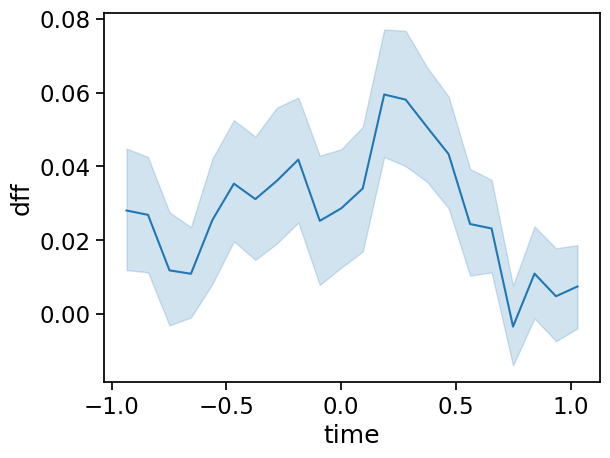

In [97]:
sns.lineplot(data=etr, x='time', y='dff')